In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, evaluate
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from scipy import stats

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['movies_metadata.csv', 'ratings.csv', 'links_small.csv', 'links.csv', 'credits.csv', 'ratings_small.csv', 'keywords.csv']


Loading essential libraries for data analysis

In [2]:
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [3]:
metadata = pd.read_csv('../input/movies_metadata.csv')
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Data preprocessing step: Filling the illegal data with the empty or nan.

In [4]:
metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [5]:
metadata['genres'] = metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
metadata['tagline'] = metadata['tagline'].fillna('')
metadata['description'] = metadata['overview'] + metadata['tagline']
metadata['description'] = metadata['description'].fillna('')

In [7]:
metadata = metadata.drop([19730, 29503, 35587])

In [8]:
metadata['title'] = metadata['title'].astype('str')
title_corpus = ' '.join(metadata['title'])

Word cloud to show the frequency of frequently used title words

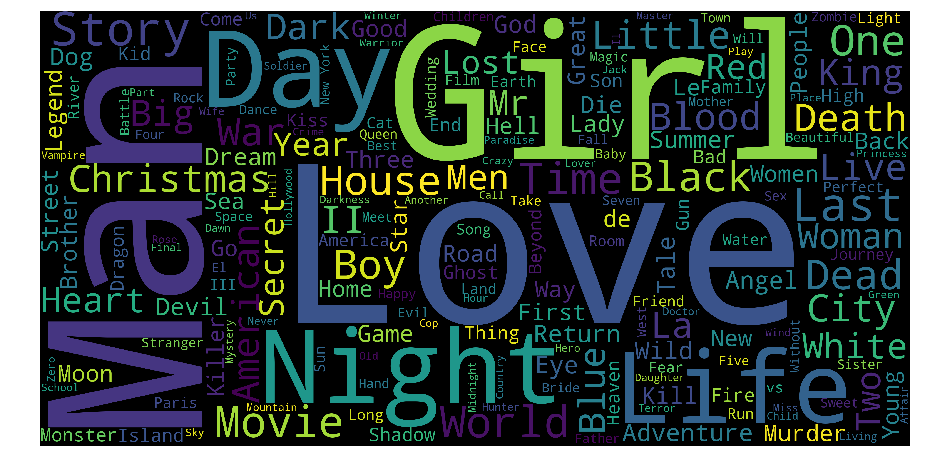

In [9]:
from wordcloud import WordCloud, STOPWORDS

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Top 10 production companies.

In [10]:
import ast
metadata['production_countries'] = metadata['production_countries'].fillna('[]').apply(ast.literal_eval)
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = metadata.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

condensedPC = metadata.drop('production_countries', axis=1).join(s)
condensedPC = pd.DataFrame(condensedPC['countries'].value_counts())
condensedPC['country'] = condensedPC.index
condensedPC.columns = ['num_movies', 'country']
condensedPC = condensedPC.reset_index().drop('index', axis=1)
condensedPC.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


Except the english language, other frequently used  languages in the movie industry.

In [12]:
metadata['original_language'].drop_duplicates().shape[0]

90

In [13]:
df_lang = pd.DataFrame(metadata['original_language'].value_counts())
df_lang['language'] = df_lang.index
df_lang.columns = ['number', 'language']
df_lang.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


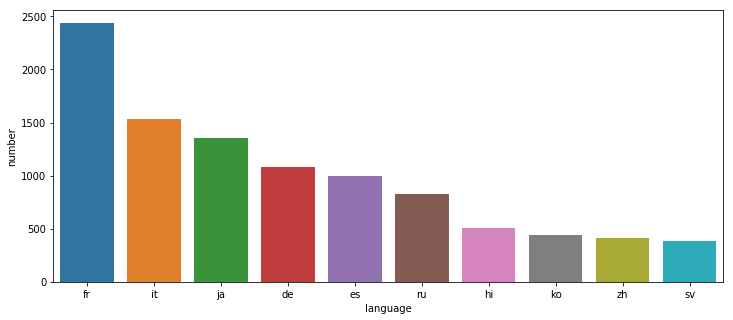

In [14]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=df_lang.iloc[1:11])
plt.show()

In [15]:
metadata[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(5)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016


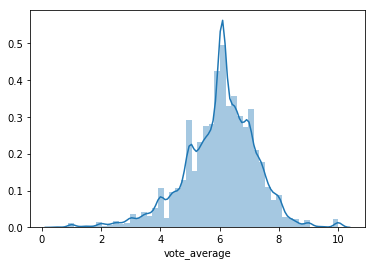

In [16]:
metadata['vote_average'] = metadata['vote_average'].replace(0, np.nan)
metadata['vote_average'].describe()
sns.distplot(metadata['vote_average'].fillna(metadata['vote_average'].median()))

In [17]:
metadata[metadata['vote_count'] > 2000][['title', 'vote_average', 'vote_count', 'year']].sort_values('vote_average', ascending=False).head(5)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975


In [18]:
def convert2float(x):
    try:
        return float(x)
    except:
        return np.nan
metadata['popularity'] = metadata['popularity'].apply(convert2float).astype('float')
metadata['vote_count'] = metadata['vote_count'].apply(convert2float).astype('float')
metadata['vote_average'] = metadata['vote_average'].apply(convert2float).astype('float')

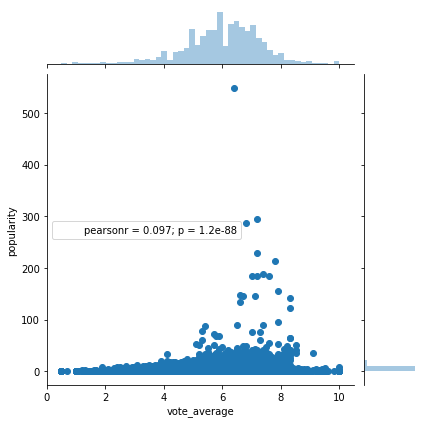

In [19]:
sns.jointplot(x='vote_average', y='popularity', data=metadata)

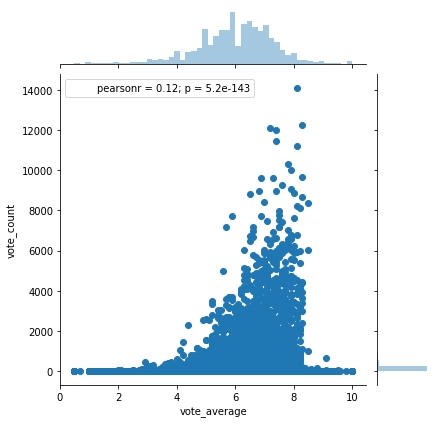

In [20]:
sns.jointplot(x='vote_average', y='vote_count', data=metadata)

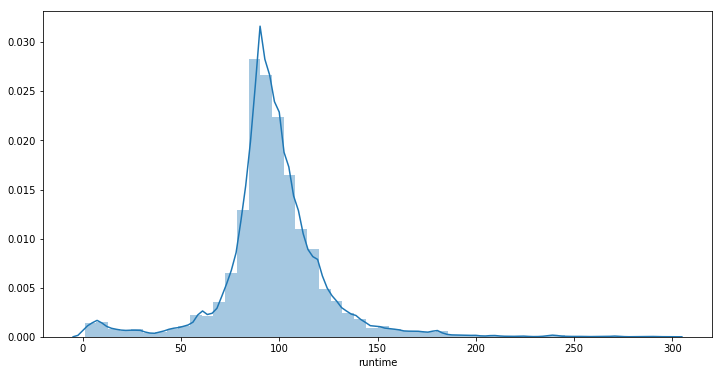

In [21]:
metadata['runtime'] = metadata['runtime'].astype('float')
plt.figure(figsize=(12,6))
sns.distplot(metadata[(metadata['runtime'] < 300) & (metadata['runtime'] > 0)]['runtime'])

***Simple Recommender***

This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.

***

***Content Based Recommender***

We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.

***

***Collaborative Filtering***

We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.

**Simple recommender**

In [22]:
vote_counts = metadata[metadata['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = metadata[metadata['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.615208892656963

In [23]:
m = vote_counts.quantile(0.95)
m

434.0

In [24]:
qualified = metadata[(metadata['vote_count'] >= m) & (metadata['vote_count'].notnull()) & (metadata['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [25]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [26]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.928665
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.918523
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.910937
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.897646
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.889020
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.886314
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.882279
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.880485
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.879385
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.871827


 **Content based filtering**
 It is based on Movie Overviews and Taglines.

In [27]:
links_small = pd.read_csv('../input/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [28]:
metadata['id'] = metadata['id'].astype('int')
smd = metadata[metadata['id'].isin(links_small)]
smd.shape

(9099, 26)

In [29]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [30]:
tfidf_matrix.shape

(9099, 268124)

In [31]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

**Cosine Similarity**


 In order to calculate a numeric quantity that denotes the similarity between two movies, the Cosine Similarity is used. Mathematically,

**cosine(x,y)=x.y⊺||x||.||y|| **

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [32]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [33]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [34]:
get_recommendations('Avatar').head(10)

2059                                    The Matrix
4506                              Tears of the Sun
4695    Lara Croft Tomb Raider: The Cradle of Life
2910               Pandora and the Flying Dutchman
538                          Hellraiser: Bloodline
7460                                    Green Zone
7587                                  The American
3015                                 House Party 2
2561                                     Supernova
975                                A Grand Day Out
Name: title, dtype: object

In [35]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [36]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [37]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7931,The Dark Knight Rises,9263,7,2012,6.938022
6144,Batman Begins,7511,7,2005,6.924355
7933,Sherlock Holmes: A Game of Shadows,3971,7,2011,6.863564
524,Batman,2145,7,1989,6.766964
7344,Law Abiding Citizen,1522,7,2009,6.692741
6667,Fracture,908,7,2007,6.552161
1113,Batman Returns,1706,6,1992,5.921963
132,Batman Forever,1529,5,1995,5.136017
8917,Batman v Superman: Dawn of Justice,7189,5,2016,5.035026
1240,Batman & Robin,1447,4,1997,4.372674


**Collaborative Filtering**

In [38]:
reader = Reader()

In [39]:
ratings = pd.read_csv('../input/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [40]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [41]:
svd = SVD()
evaluate(svd, data, measures=['RMSE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8898
MAE:  0.6873
------------
Fold 2
RMSE: 0.9085
MAE:  0.6983
------------
Fold 3
RMSE: 0.8928
MAE:  0.6853
------------
Fold 4
RMSE: 0.9022
MAE:  0.6944
------------
Fold 5
RMSE: 0.8966
MAE:  0.6908
------------
------------
Mean RMSE: 0.8980
Mean MAE : 0.6912
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.6872730129605765,
                             0.6983056083936434,
                             0.6852968353499852,
                             0.694388732320777,
                             0.6907912145871016],
                            'rmse': [0.8898352473274738,
                             0.9085079714153531,
                             0.8928114652222043,
                             0.9022122061170392,
                             0.8966419197713484]})

In [42]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [43]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [44]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6018283951374452, details={'was_impossible': False})